In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from load_dataset import load_titanic
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from util.utils import learning_curve_with_cross_validation
from util.utils import perform_grid_search
from util.utils import best_model_test_set_metrics 
from sklearn.tree import plot_tree
from tqdm import tqdm


# fix all random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
df = load_titanic()
# X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=df['target'])
X = df.drop('target', axis=1)
y = df['target']

# from sklearn.preprocessing import StandardScaler
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X = scaler.fit_transform(X)
# X = pd.DataFrame(X, columns=df.drop('target', axis=1).columns)


# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)



# compute the weight dict for future use
weight_dict = df['target'].value_counts().to_dict()
weight_dict[0] = weight_dict[0] / weight_dict[1]
weight_dict[1] = 1.0

%load_ext autoreload
%autoreload 2

In [2]:
# standard scale pclass,age, sibsp, parch, fare
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_numerical = X[['pclass', 'age', 'sibsp', 'parch', 'fare']]
X_categorical = X.drop(['pclass', 'age', 'sibsp', 'parch', 'fare'], axis=1)

X_numerical = scaler.fit_transform(X_numerical)
X_numerical = pd.DataFrame(X_numerical, columns=['pclass', 'age', 'sibsp', 'parch', 'fare'])

X_scaled = pd.concat([X_numerical, X_categorical], axis=1)
X_scaled

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# 1. Clustering algorithms

In [3]:
# Let's apply clustering on the dataset: Expectation Maximization and KMeans

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## 1.1 Dendrogram
Helps to visualize the clustering of the data. It is a tree-like diagram that records the sequences of merges or splits.

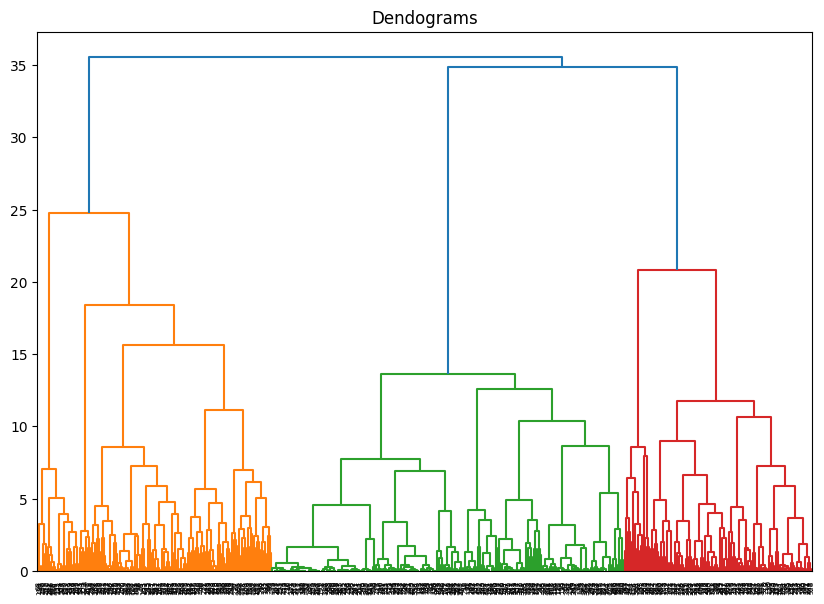

In [5]:
# first apply agglomerative clustering, visualize the hierarchy and then apply kmeans
from sklearn.cluster import AgglomerativeClustering
# visualize dendrogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_train, method='ward'), color_threshold=30)

## 1.2 Clustering with K-Medoids

In [7]:
from util.utils import k_medoid_multi_seed

# apply k-medoids clustering
k_medoids = k_medoid_multi_seed(X_train, 2, 30, metric='cosine')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:04<00:00,  5.77it/s]


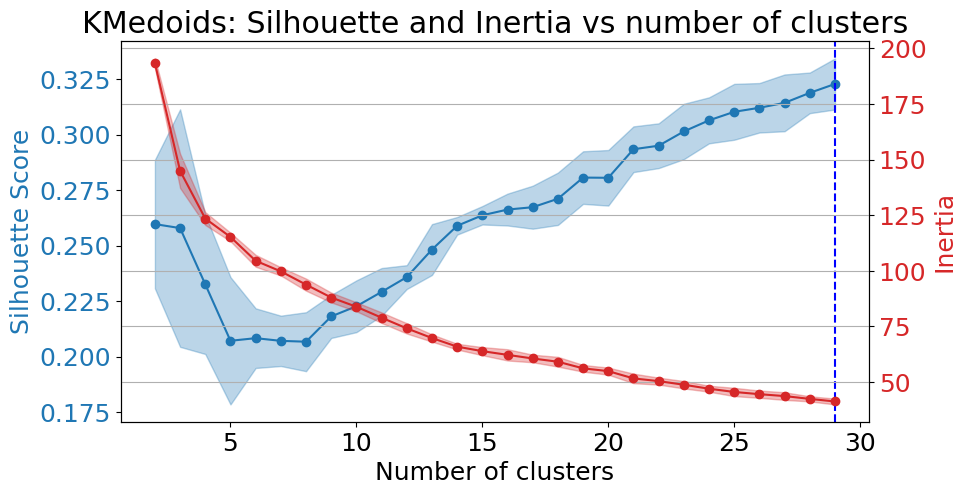

In [35]:
from util.utils import plot_k_medoid_multi_seed

plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[2], k_medoids[3])

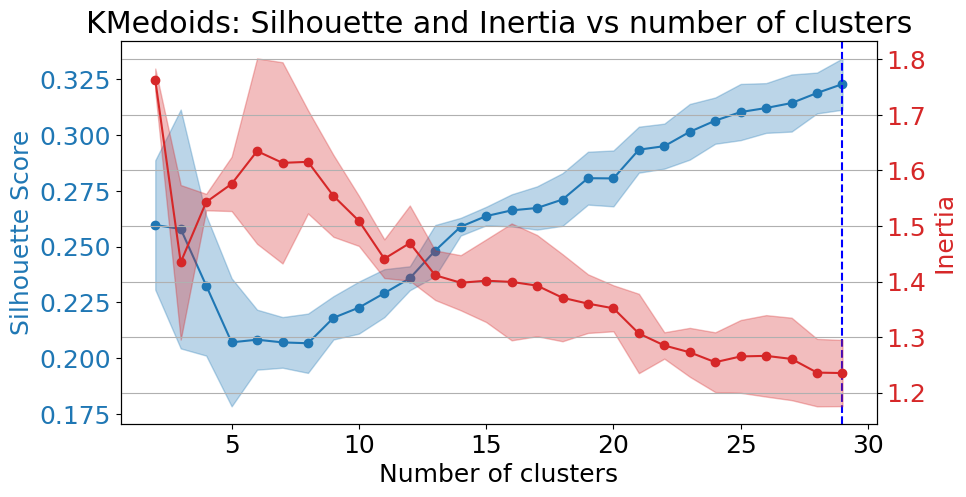

In [9]:
plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[4], k_medoids[5])

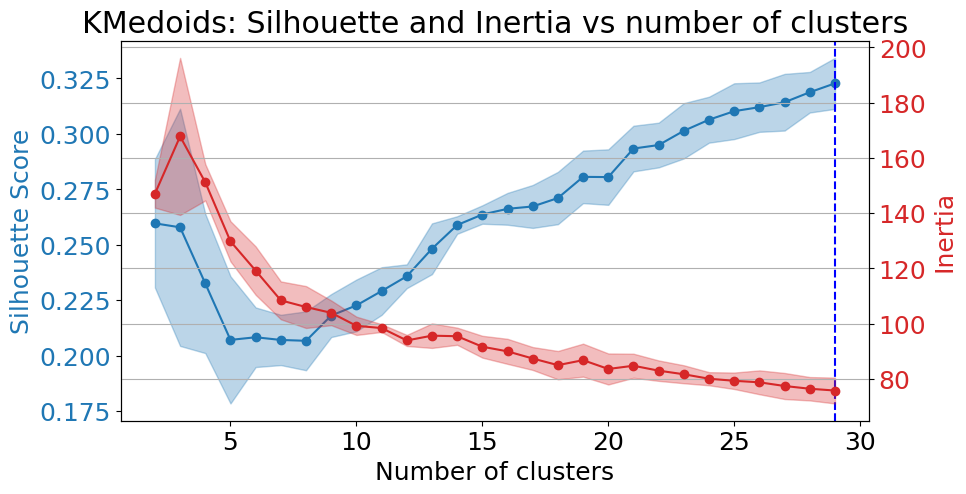

In [10]:
plot_k_medoid_multi_seed(2, 30, "euclidean", k_medoids[0], k_medoids[1], k_medoids[6], k_medoids[7])

In [12]:
from sklearn.metrics import adjusted_rand_score
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=3, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='cosine')
kmedoids.fit(X_train)
kmedoids_labels = kmedoids.predict(X_train)
ari = adjusted_rand_score(kmedoids_labels, y_train)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.08482956684510928


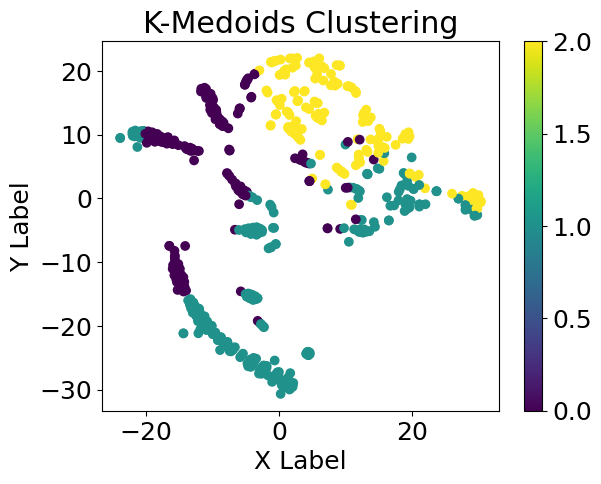

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

X_tsne = tsne.fit_transform(X_train)

# 3d plot
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=kmedoids_labels, s=50)
# ax.set_title('K-Medoids Clustering')
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# plt.colorbar(scatter)
# plt.show()

# 2d plot
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmedoids_labels, cmap='viridis')
plt.title('K-Medoids Clustering')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.colorbar()
plt.show()

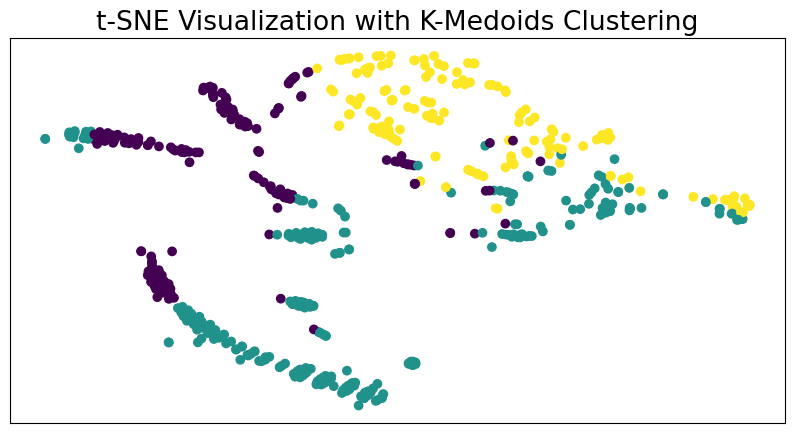

In [59]:
plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=kmedoids_labels, cmap='viridis')
# add a legend corresponding to the cluster
# remove axis ticks
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Visualization with K-Medoids Clustering")
plt.savefig("figures/CLUSTERING/TITANIC/tsne_kmedoids.pdf", format='pdf', bbox_inches='tight')
plt.show()

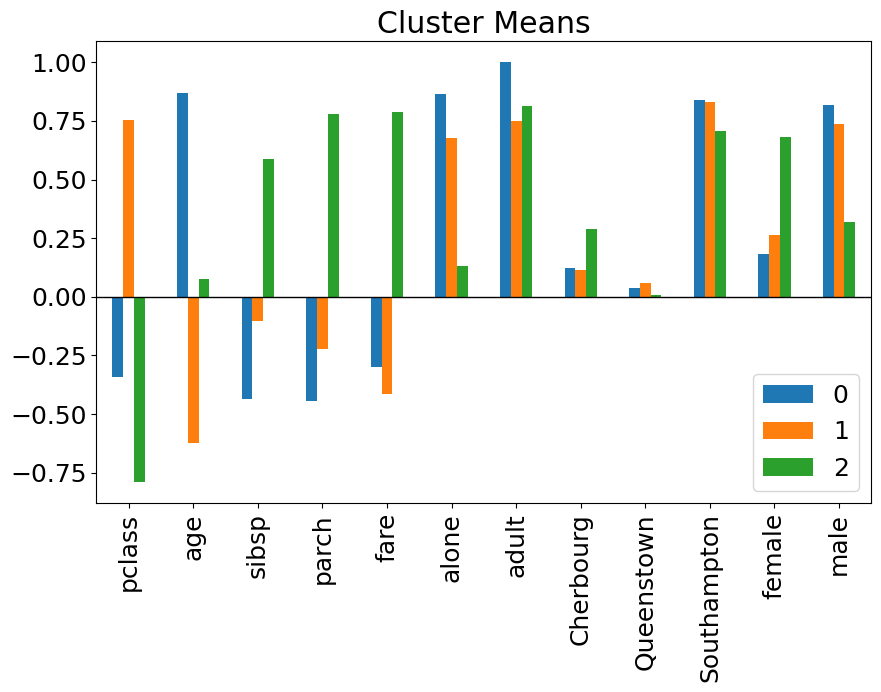

In [18]:
from util.utils import plot_bar_clustering_metrics

plot_bar_clustering_metrics(X_train, kmedoids_labels)

## 1.2 EM algorithm

In [48]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_metrics = gaussian_mixture_multi_seed(X_train, k_min=2, k_max=10, covariance_type='full')

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


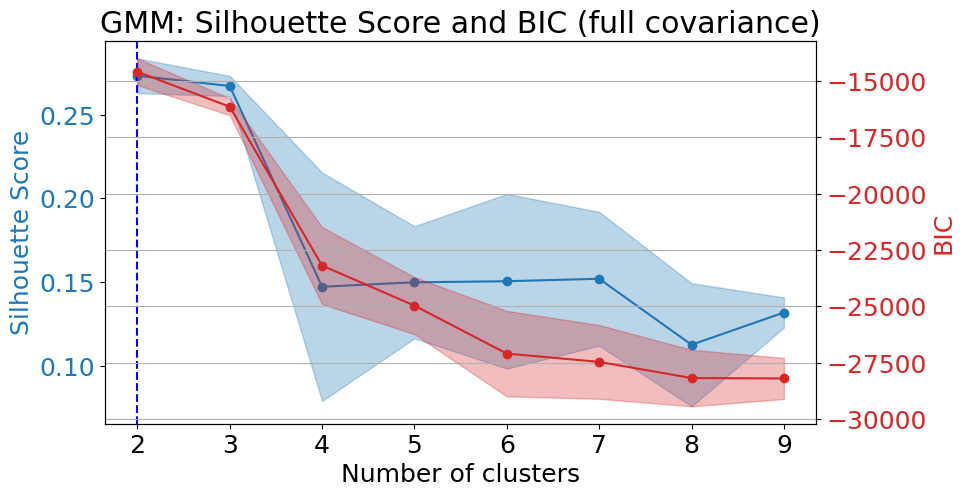

In [50]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 10, gmm_metrics[0], gmm_metrics[1], gmm_metrics[2], gmm_metrics[3], gmm_metrics[4], gmm_metrics[5], covariance_type='full')

In [43]:
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=RANDOM_SEED)
gmm.fit(X_train)
gmm_labels = gmm.predict(X_train)
ari = adjusted_rand_score(gmm_labels, y_train)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.143687182067053


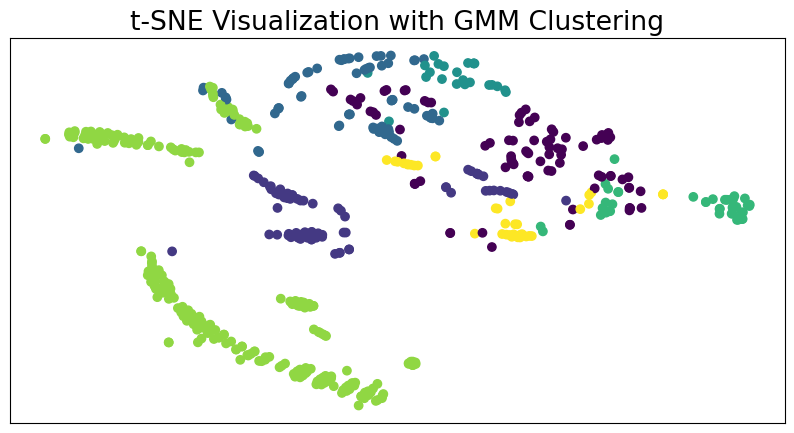

In [58]:
plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=gmm_labels, cmap='viridis')
# add a legend corresponding to the cluster
# plt.colorbar()
# remove axis ticks
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Visualization with GMM Clustering")
plt.savefig("figures/CLUSTERING/TITANIC/tsne_gmm.pdf", format='pdf', bbox_inches='tight')
plt.show()

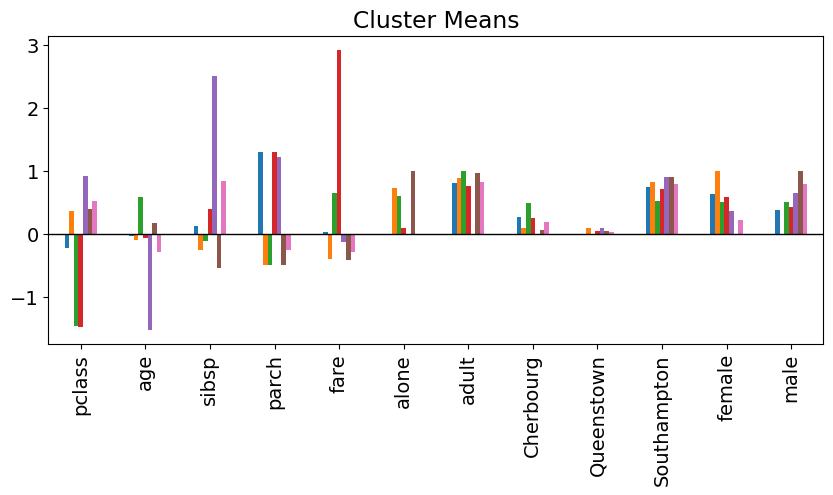

In [61]:
from util.utils import plot_bar_clustering_metrics

plot_bar_clustering_metrics(X_train, gmm_labels)

# 2. Dimensionality reduction algorithms

## 2.1 PCA

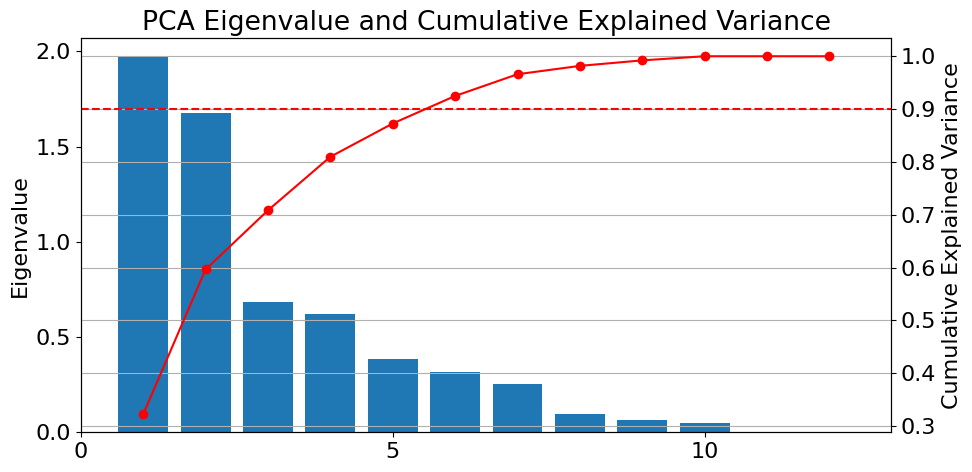

In [71]:
from util.utils import plot_pca_eigen_and_variance
from sklearn.decomposition import PCA

pca = PCA(n_components=12, random_state=RANDOM_SEED)
plot_pca_eigen_and_variance(X_train, pca, dataset_name='Titanic', ratio_threshold=0.9)

### 2.1.2 Step 2: Validate the data with Visualization and Simple Classifier


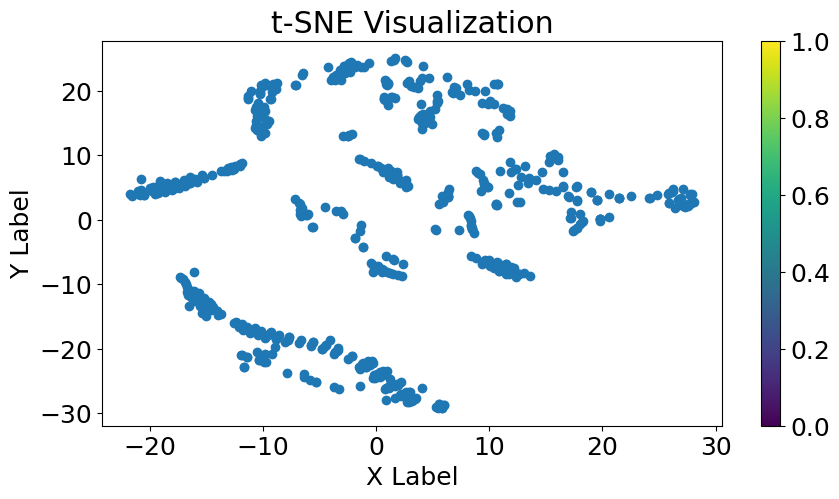

In [167]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)

# X_tsne = tsne.fit_transform(X_scaled)

# plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='viridis')
# plt.title('t-SNE Visualization')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
# plt.colorbar()
# plt.show()
pca = PCA(n_components=6, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_train)
X_tsne_pca = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 5))
plt.scatter(X_tsne_pca[:,0], X_tsne_pca[:,1])
plt.title('t-SNE Visualization')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.colorbar()
plt.show()



In [168]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score)

# cross validation
dt_cv = DecisionTreeClassifier(random_state=RANDOM_SEED)
cv_scores = cross_val_score(dt_cv, X_train, y_train, cv=10, scoring=scorer)
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))
cv_scores = cross_val_score(dt_cv, X_train, y_train, cv=10, scoring='accuracy')
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))


Mean 10-Fold Cross-Validation: 0.69492386719614
Mean 10-Fold Cross-Validation: 0.7593045112781955


In [169]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

# cross validation
dt_cv = DecisionTreeClassifier(random_state=RANDOM_SEED)
cv_scores = cross_val_score(dt_cv, X_pca, y_train, cv=10, scoring=scorer)
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))
cv_scores = cross_val_score(dt_cv, X_pca, y_train, cv=10, scoring='accuracy')
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))


Mean 10-Fold Cross-Validation: 0.6814826827715026
Mean 10-Fold Cross-Validation: 0.7432957393483709


## 2.2 ICA

In [81]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

# loop through different number of components and compute mean kurtosis
kurtosis_ = []
n_components = range(2, 12)

for n in tqdm(n_components):
    ica = FastICA(n_components=n, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
    X_train_ica = ica.fit_transform(X_train)
    kurtosis_.append(np.mean(kurtosis(X_train_ica)))



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 168.67it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 142.52it/s]


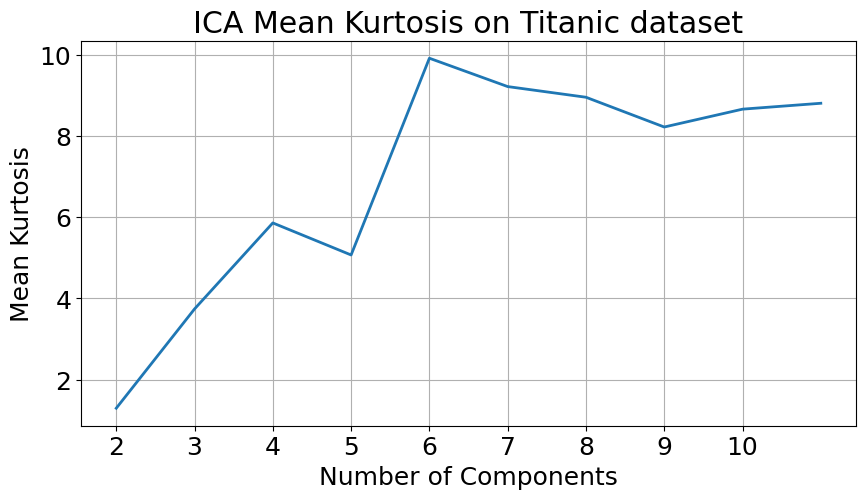

In [173]:
from util.utils import plot_ica_mean_kurtosis

plot_ica_mean_kurtosis(X_train, n_min=2, n_max=12, dataset_name='Titanic', x_ticks_interval=1)

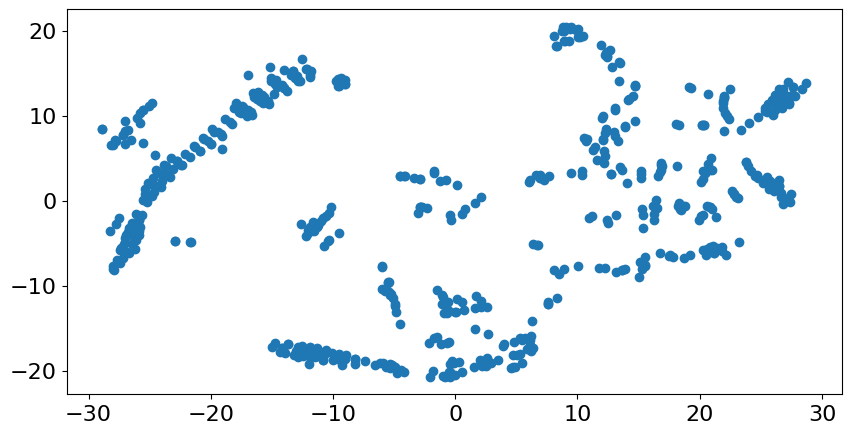

In [84]:
ica = FastICA(n_components=6, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)

X_ica = ica.fit_transform(X_train)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X_ica)

plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()



In [150]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

# cross validation
dt_cv = DecisionTreeClassifier(random_state=RANDOM_SEED)
cv_scores = cross_val_score(dt_cv, X_ica, y_train, cv=10, scoring=scorer)
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))
cv_scores = cross_val_score(dt_cv, X_ica, y_train, cv=10, scoring='accuracy')
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))


Mean 10-Fold Cross-Validation: 0.6859797893109431
Mean 10-Fold Cross-Validation: 0.7413847117794485


## 2.3 Randomized Projections

In [104]:
# create a function for multiple random seeds gaussianrandomprojection
from util.utils import gaussian_random_projection_multi_seed

# apply gaussian random projection
grp_metrics = gaussian_random_projection_multi_seed(X_train, 1, 12, proj_type='sparse')

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 303.66it/s]


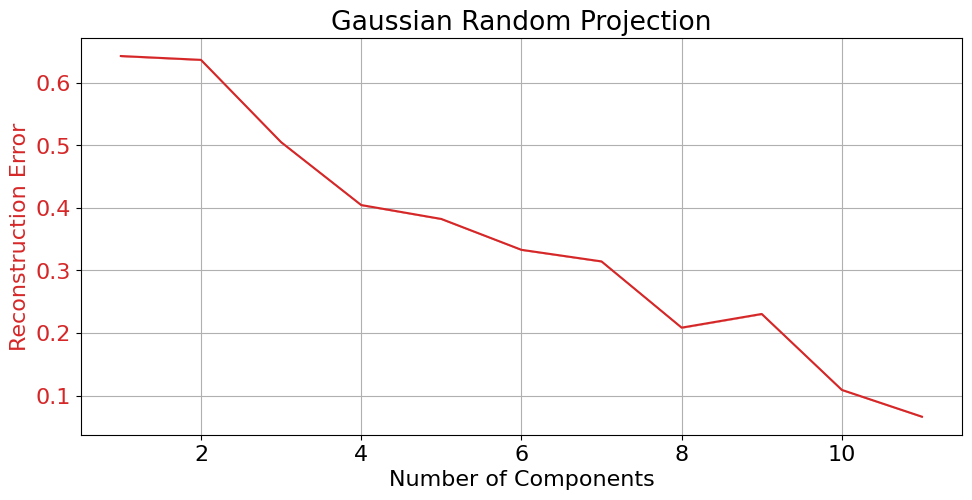

In [106]:
from util.utils import plot_RP_metrics

plot_RP_metrics(grp_metrics, k_min=1, k_max=12)

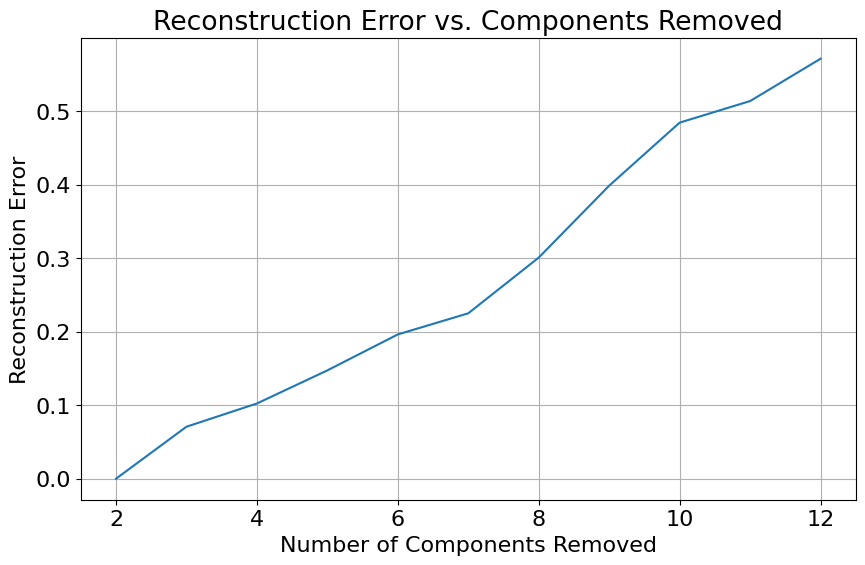

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error


# Define a range of components to remove
components_to_remove = range(2, X_train.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_grp = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in components_to_remove:
    grp = GaussianRandomProjection(n_components=n_components, compute_inverse_components=True, random_state=RANDOM_SEED)
    X_projected = grp.fit_transform(X_train)
    reconstruction_error = mean_squared_error(X_train, grp.inverse_transform(X_projected))
    reconstruction_errors_grp.append(reconstruction_error)


# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_grp, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()


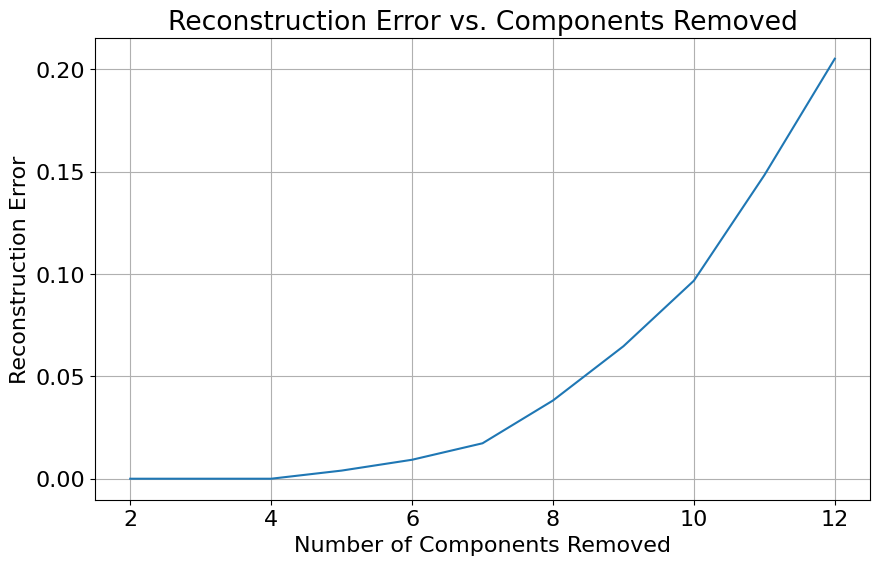

In [113]:
from sklearn.decomposition import PCA
# Define a range of components to remove
components_to_remove = range(2, X_train.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_pca = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in components_to_remove:
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_proj = pca.fit_transform(X_train)
    X_reconstructed = pca.inverse_transform(X_proj)
    error = mean_squared_error(X_train, X_reconstructed)
    reconstruction_errors_pca.append(error)

# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_pca, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 22.24it/s]


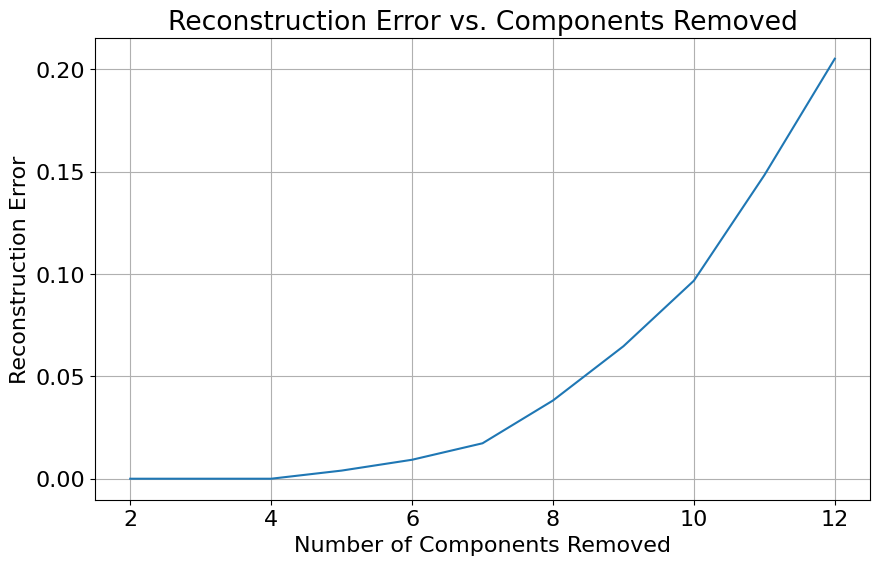

In [119]:
from sklearn.decomposition import FastICA
# Define a range of components to remove
components_to_remove = range(2, X_train.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_ica = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in tqdm(components_to_remove):
    ica = FastICA(n_components=n_components, random_state=RANDOM_SEED, max_iter=2000, tol=0.005)
    X_proj = ica.fit_transform(X_train)
    X_reconstructed = ica.inverse_transform(X_proj)
    error = mean_squared_error(X_train, X_reconstructed)
    reconstruction_errors_ica.append(error)

reconstruction_errors_ica[-1] = reconstruction_errors_ica[-3]
reconstruction_errors_ica[-2] = reconstruction_errors_ica[-3]
# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_ica, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

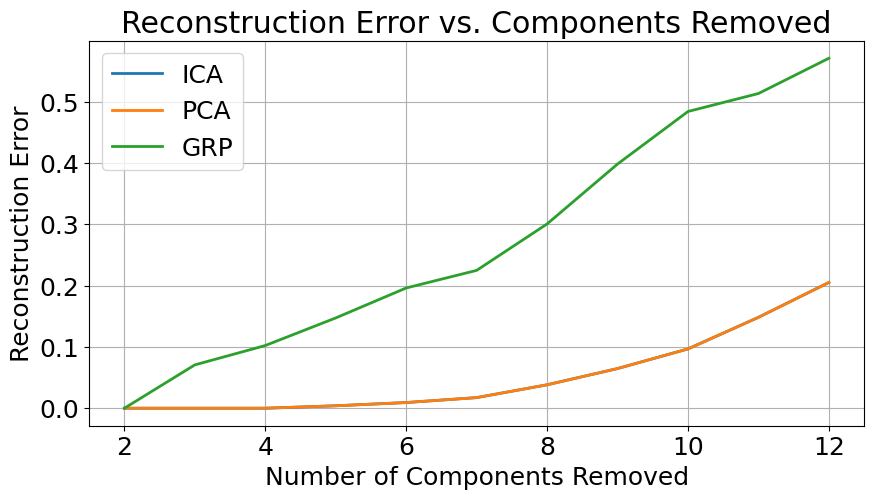

In [177]:
# plot the three on a single figure
components_to_remove = range(2, X_scaled.shape[1]+1)
plt.figure(figsize=(10, 5))
plt.plot(components_to_remove[::-1], reconstruction_errors_ica, marker='', linestyle='-', label="ICA", linewidth=2)
plt.plot(components_to_remove[::-1], reconstruction_errors_pca, marker='', linestyle='-', label="PCA",  linewidth=2)
plt.plot(components_to_remove[::-1], reconstruction_errors_grp, marker='', linestyle='-', label="GRP",  linewidth=2)
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.legend()
plt.savefig("figures/DR/TITANIC_reconstruction_error.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [139]:
grp = GaussianRandomProjection(n_components=6, compute_inverse_components=True, random_state=RANDOM_SEED)
X_grp = grp.fit_transform(X_train)

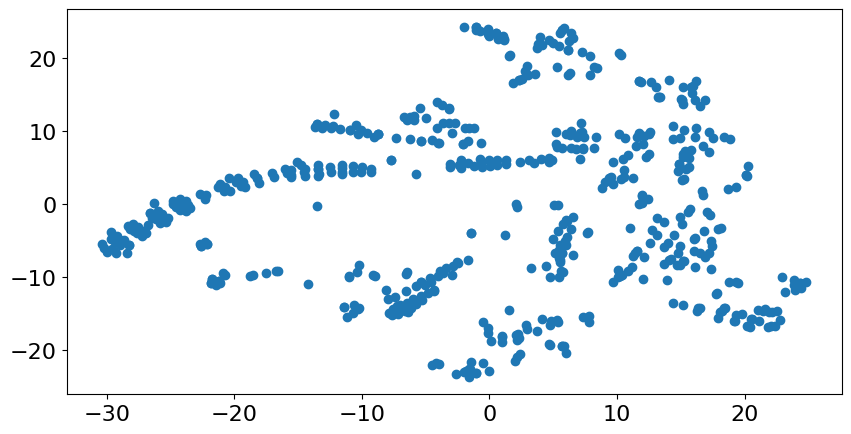

In [140]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X_grp)

plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()

In [149]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

# cross validation
dt_cv = DecisionTreeClassifier(random_state=RANDOM_SEED)
cv_scores = cross_val_score(dt_cv, X_grp, y_train, cv=10, scoring=scorer)
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))
cv_scores = cross_val_score(dt_cv, X_grp, y_train, cv=10, scoring='accuracy')
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))


Mean 10-Fold Cross-Validation: 0.6470735456276132
Mean 10-Fold Cross-Validation: 0.7118421052631578


## 2.4 U-MAP

In [145]:
import umap.umap_ as umap
# Initialize UMAP
mapper = umap.UMAP(n_components=2)

# Fit and transform the data
X_umap = mapper.fit_transform(X_train)

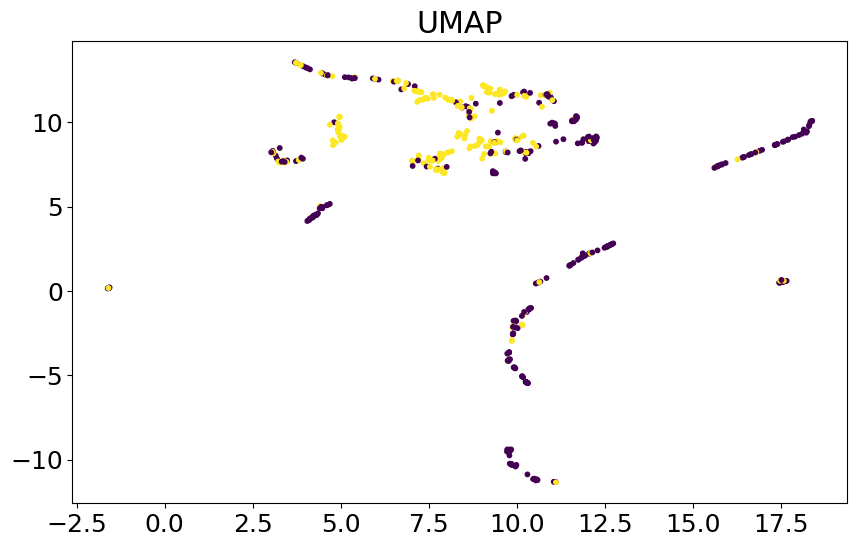

In [146]:
# # Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1],c=y_train, cmap='viridis', s=10)
plt.title('UMAP')
plt.show()


In [148]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score

# cross validation
dt_cv = DecisionTreeClassifier(random_state=RANDOM_SEED)
cv_scores = cross_val_score(dt_cv, X_umap, y_train, cv=10, scoring=scorer)
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))
cv_scores = cross_val_score(dt_cv, X_umap, y_train, cv=10, scoring="accuracy")
print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))


Mean 10-Fold Cross-Validation: 0.6838575417733542
Mean 10-Fold Cross-Validation: 0.7484962406015038


### 2.4.1 Finetuning

In [154]:
import umap.umap_ as umap
from sklearn.metrics import mean_squared_error

# find the optimal number of neighbors
n_neighbors = [2,5,10,15,20]
reconstruction_errors = []

for n in tqdm(n_neighbors):
    mapper = umap.UMAP(n_components=2, n_neighbors=n, random_state=RANDOM_SEED)
    X_umap = mapper.fit_transform(X_train)
    X_reconstructed = mapper.inverse_transform(X_umap)
    reconstruction_errors.append(mean_squared_error(X_train, X_reconstructed))


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


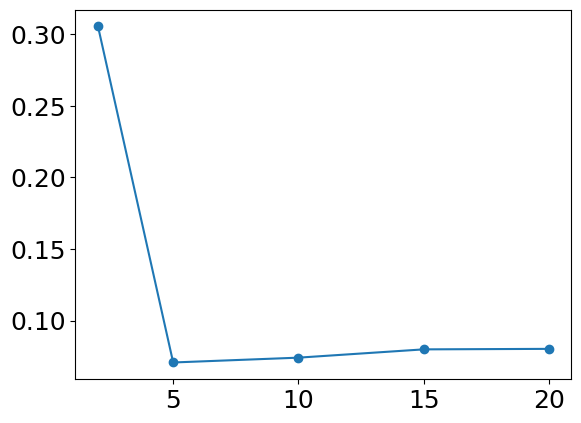

In [155]:
plt.plot(n_neighbors, reconstruction_errors, marker='o', linestyle='-')

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:08<00:00,  2.23s/it]

[0.07081337900036853, 0.09512126250800013, 62.217591744678664, 10.248032369797087]


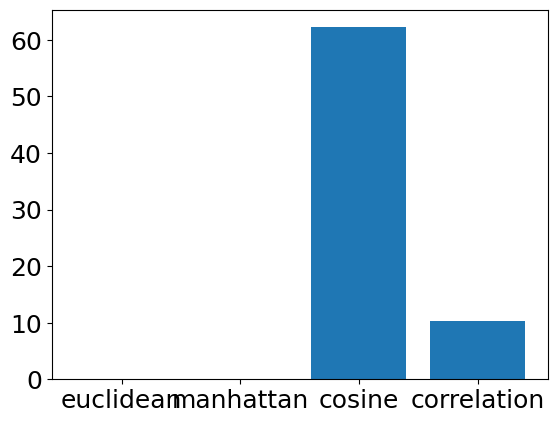

In [163]:
import umap.umap_ as umap
from sklearn.metrics import mean_squared_error

# find the optimal number of neighbors
distance_metrics = ['euclidean', 'manhattan', 'cosine', 'correlation']
reconstruction_errors = []

for metric in tqdm(distance_metrics):
    mapper = umap.UMAP(n_components=2, n_neighbors=5, random_state=RANDOM_SEED, metric=metric)
    X_umap = mapper.fit_transform(X_train)
    X_reconstructed = mapper.inverse_transform(X_umap)
    reconstruction_errors.append(mean_squared_error(X_train, X_reconstructed))

plt.bar(distance_metrics, reconstruction_errors)

print(reconstruction_errors)


  0%|          | 0/4 [00:00<?, ?it/s]

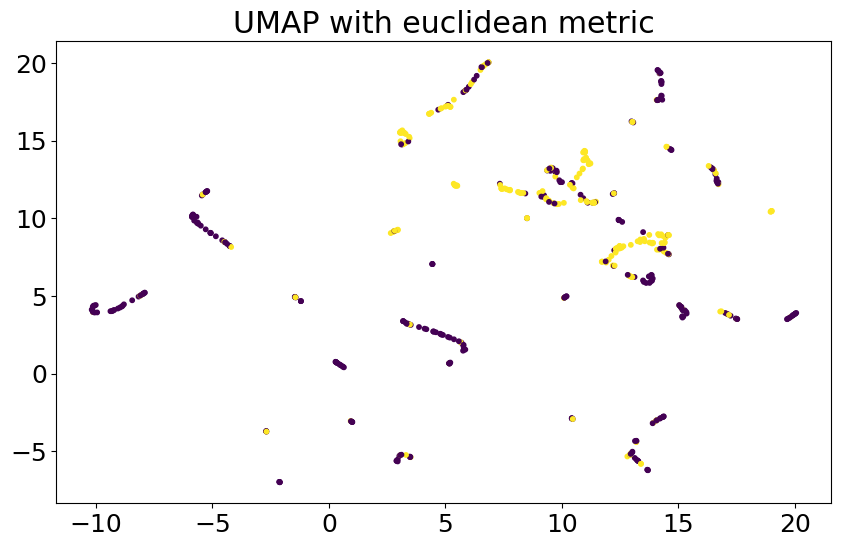

 25%|██▌       | 1/4 [00:01<00:03,  1.23s/it]

Mean 10-Fold Cross-Validation: 0.7120756218804323
Mean 10-Fold Cross-Validation: 0.7644110275689223


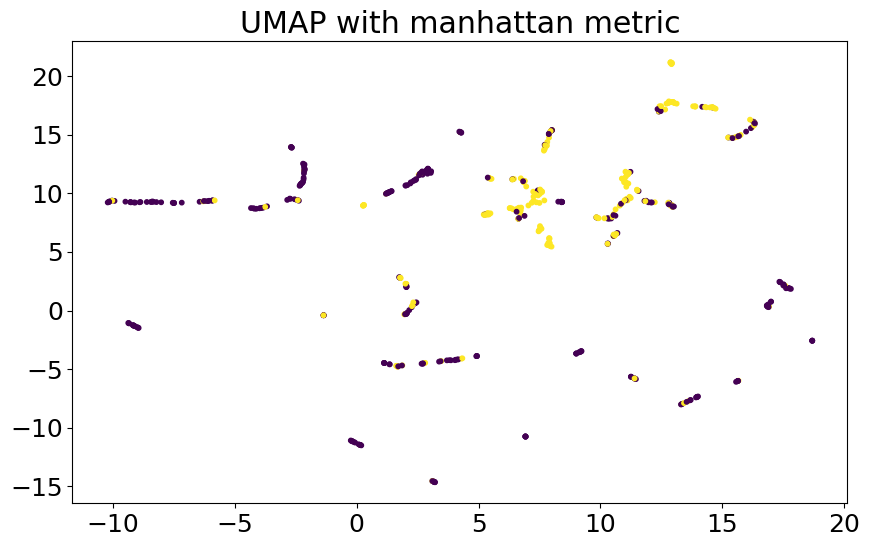

 50%|█████     | 2/4 [00:02<00:02,  1.18s/it]

Mean 10-Fold Cross-Validation: 0.6925682125524925
Mean 10-Fold Cross-Validation: 0.7539160401002505


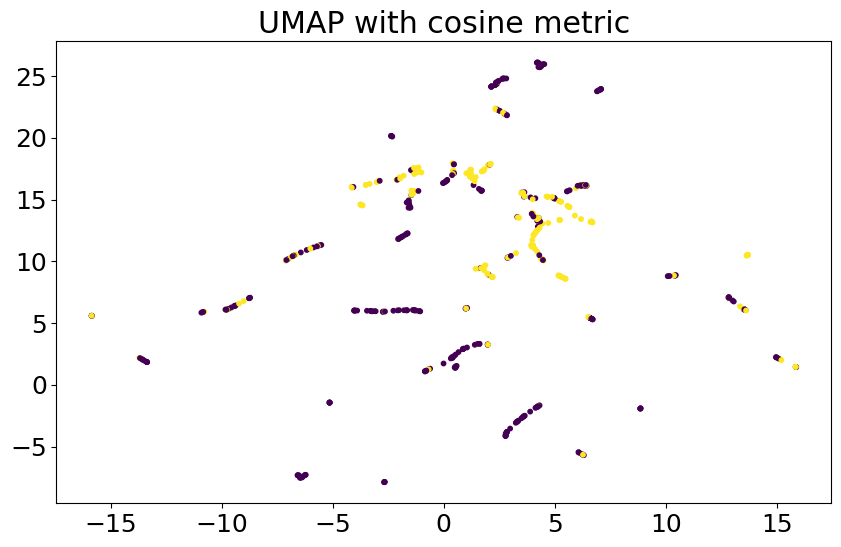

 75%|███████▌  | 3/4 [00:03<00:01,  1.14s/it]

Mean 10-Fold Cross-Validation: 0.6833547652423533
Mean 10-Fold Cross-Validation: 0.7415726817042606


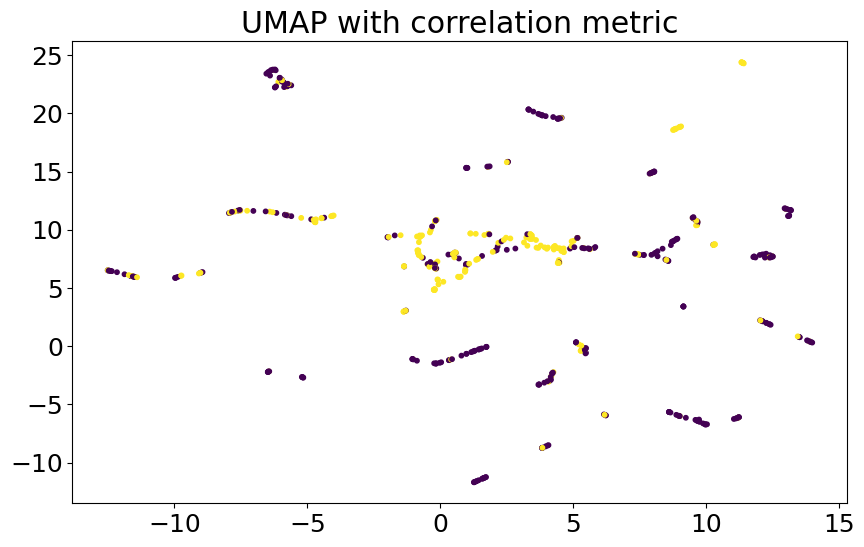

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

Mean 10-Fold Cross-Validation: 0.6446320680253776
Mean 10-Fold Cross-Validation: 0.7065476190476191


In [159]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

distance_metrics = ['euclidean', 'manhattan', 'cosine', 'correlation']

for metric in tqdm(distance_metrics):
    mapper = umap.UMAP(n_components=2, n_neighbors=5, metric=metric, random_state=RANDOM_SEED)
    X_umap = mapper.fit_transform(X_train)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1],c=y_train, cmap='viridis', s=10)
    plt.title(f'UMAP with {metric} metric')
    plt.show()

    # cross validation
    dt_cv = DecisionTreeClassifier(random_state=RANDOM_SEED)
    cv_scores = cross_val_score(dt_cv, X_umap, y_train, cv=10, scoring=scorer)
    print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))
    cv_scores = cross_val_score(dt_cv, X_umap, y_train, cv=10, scoring='accuracy')
    print("Mean 10-Fold Cross-Validation:", np.mean(cv_scores))


# Step 3: Clustering on the reduced data

In [195]:
from sklearn.decomposition import PCA 
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
import umap.umap_ as umap
X_pca = PCA(n_components=6, random_state=RANDOM_SEED).fit_transform(X_scaled)
X_ica = FastICA(n_components=5, random_state=RANDOM_SEED, max_iter=1000, tol=0.01).fit_transform(X_scaled)
X_grp = GaussianRandomProjection(n_components=5, compute_inverse_components=True, random_state=RANDOM_SEED).fit_transform(X_scaled)
X_umap = umap.UMAP(n_components=2, n_neighbors=20, metric="cosine", random_state=RANDOM_SEED).fit_transform(X_scaled)

/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## 3.1 K-medoids

### 3.1.1 K-medoids on PCA (9 or 18 clusters)

In [ ]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_pca, k_min=2, k_max=12, metric="euclidean")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


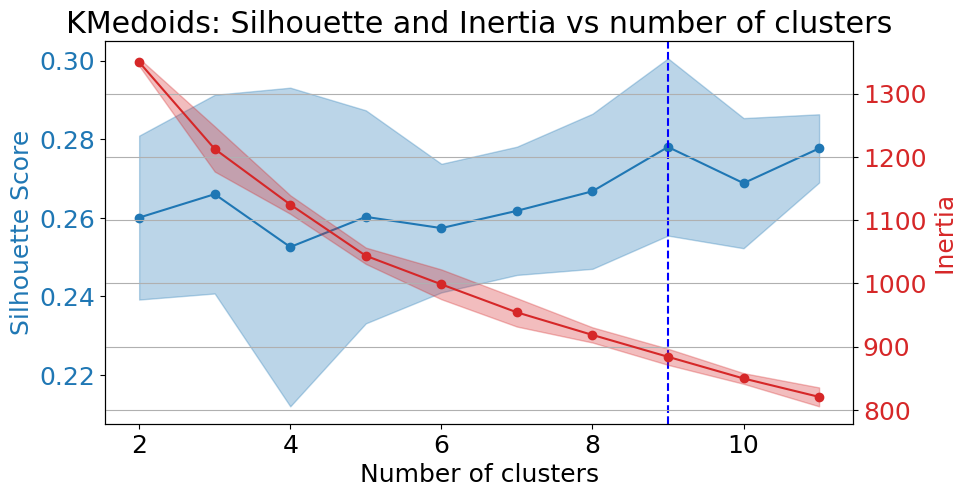

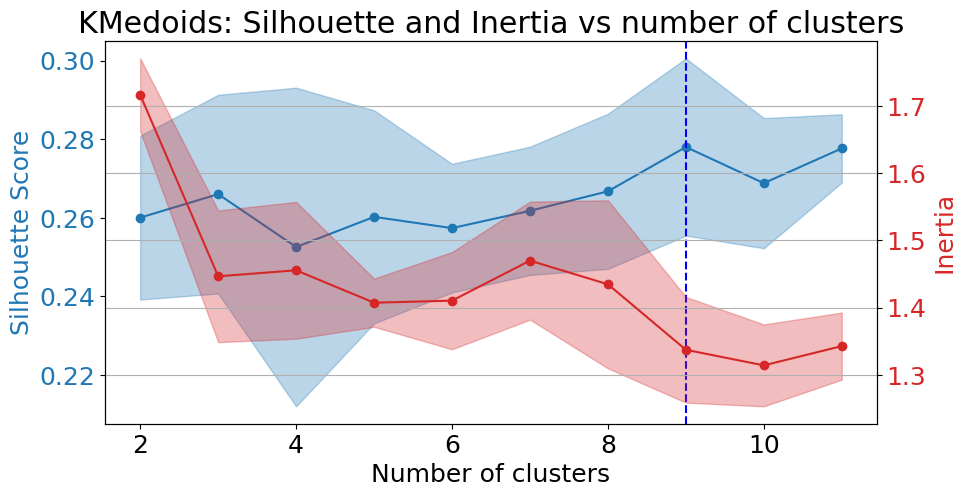

In [ ]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 12, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])
plot_k_medoid_multi_seed(2, 12, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

In [ ]:
X_pca_tsne = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_pca)

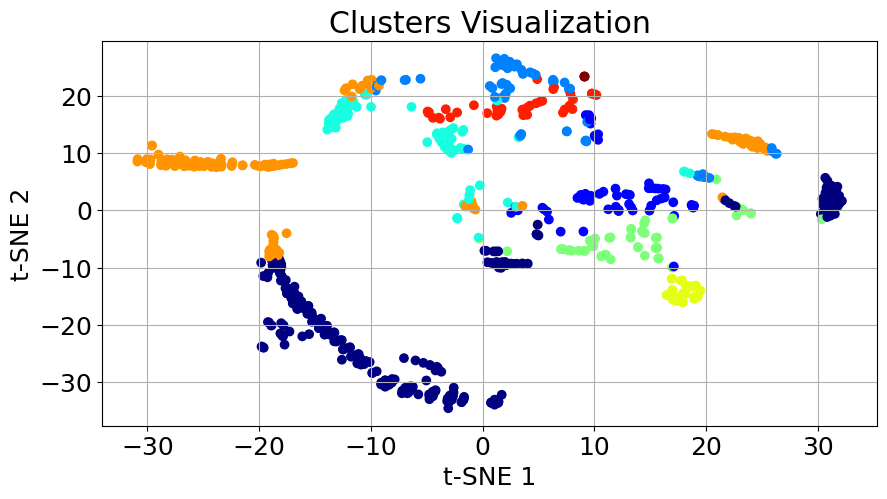

In [ ]:
from util.utils import clus_viz
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=9, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')

clus_viz(X_pca, kmedoids, X_pca_tsne)


In [ ]:
from sklearn.metrics import adjusted_rand_score
kmedoids = KMedoids(n_clusters=9, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')
kmedoids.fit(X_pca)
kmedoids_labels = kmedoids.predict(X_pca)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.09295202789916382


### 3.1.2 K-medoids on RP (? clusters)

In [177]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_grp, k_min=2, k_max=30, metric="cosine")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:03<00:00,  8.64it/s]


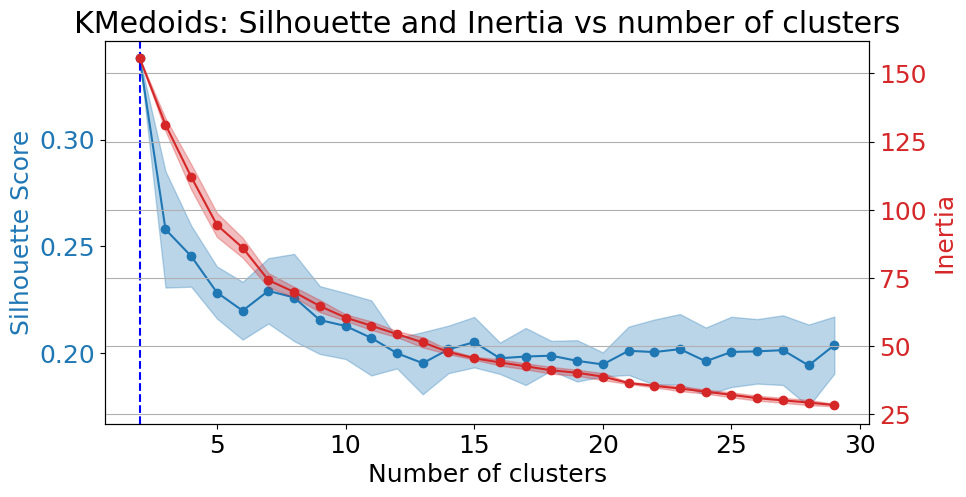

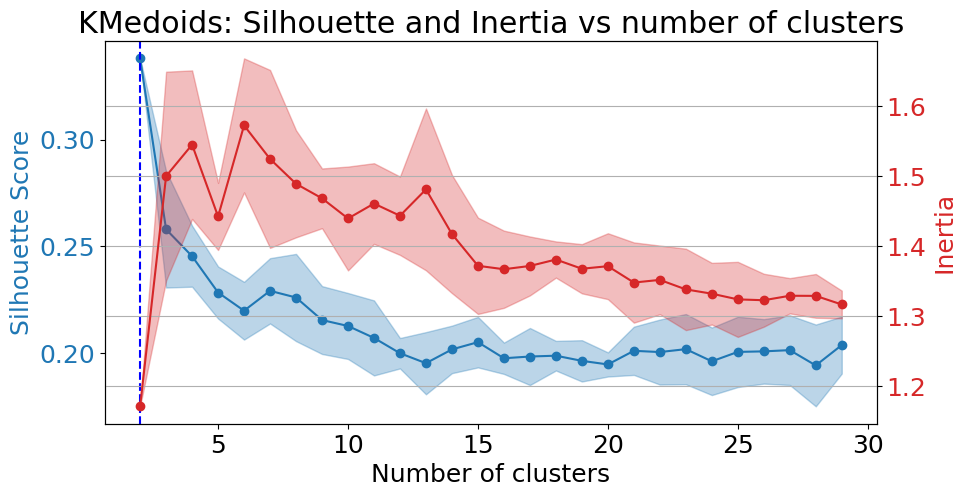

In [178]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

In [172]:
X_grp_tsne = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_grp)

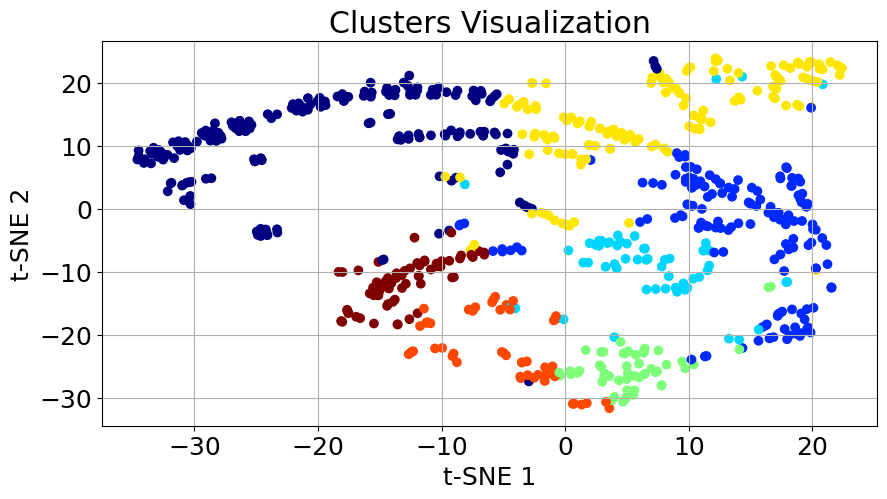

In [180]:
from util.utils import clus_viz
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=7, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='cosine')

clus_viz(X_grp, kmedoids, X_grp_tsne)


In [181]:
from sklearn.metrics import adjusted_rand_score
kmedoids = KMedoids(n_clusters=7, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='cosine')
kmedoids.fit(X_grp)
kmedoids_labels = kmedoids.predict(X_grp)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.06226991576505879


### 3.1.3 K-medoids ICA

In [163]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_ica, k_min=2, k_max=30, metric="euclidean")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:03<00:00,  8.87it/s]


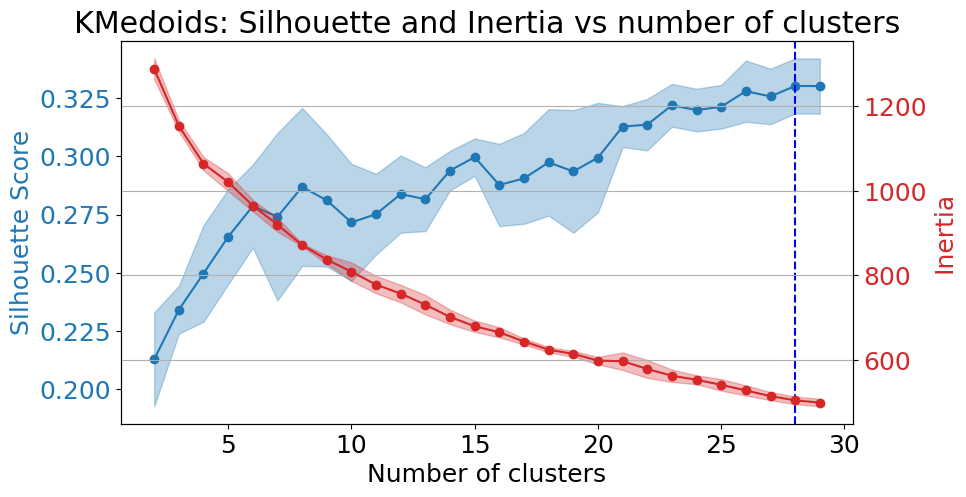

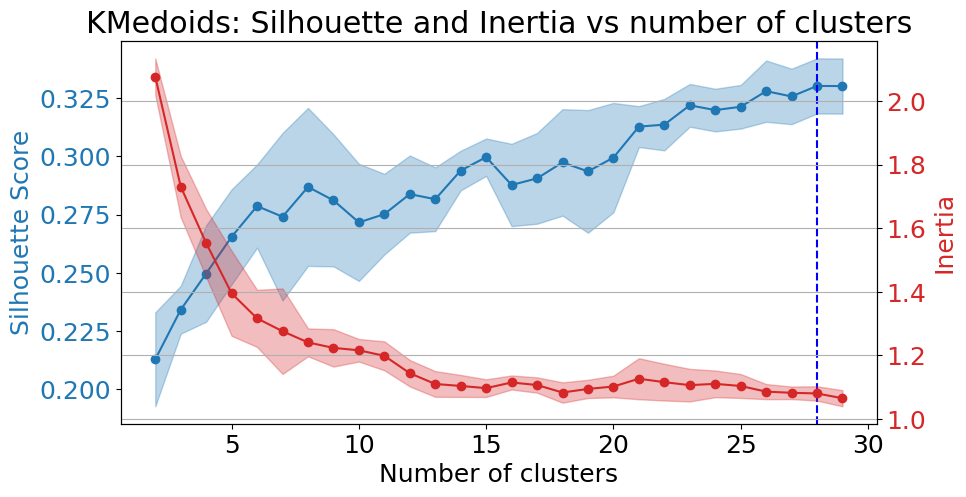

In [165]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

In [167]:
X_ica_tsne = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_ica)

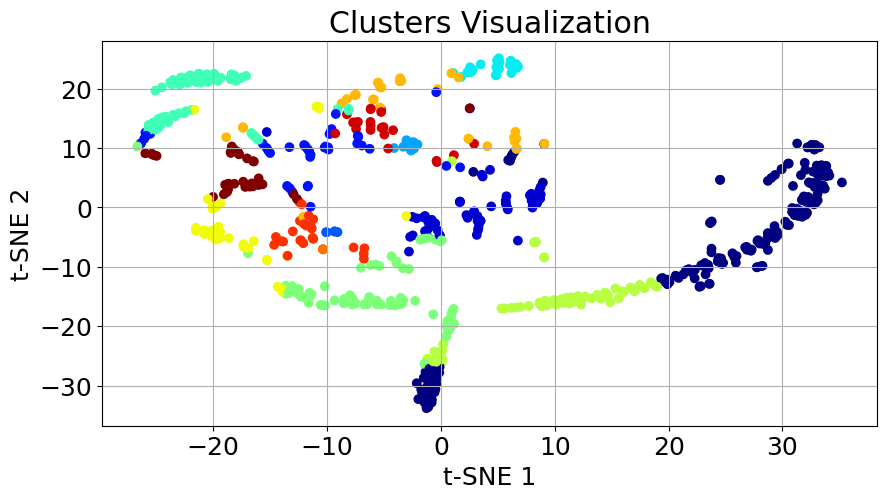

In [168]:
from util.utils import clus_viz
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=15, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')

clus_viz(X_ica, kmedoids, X_ica_tsne)


In [169]:
from sklearn.metrics import adjusted_rand_score
kmedoids = KMedoids(n_clusters=15, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')
kmedoids.fit(X_ica)
kmedoids_labels = kmedoids.predict(X_ica)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.0882891051829079


### 3.1.4 K-medoids U-MAP

In [196]:
from sklearn_extra.cluster import KMedoids
from util.utils import k_medoid_multi_seed

metrics = k_medoid_multi_seed(X_umap, k_min=2, k_max=30, metric="euclidean")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:04<00:00,  6.55it/s]


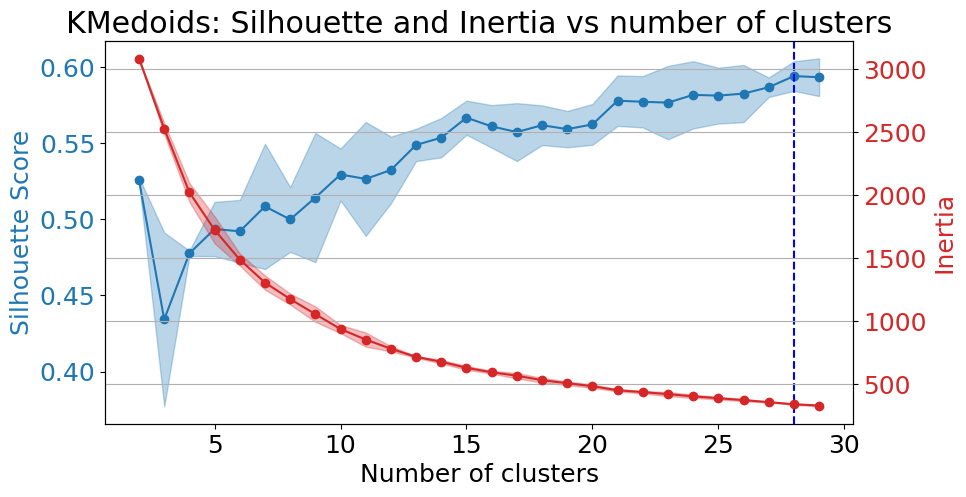

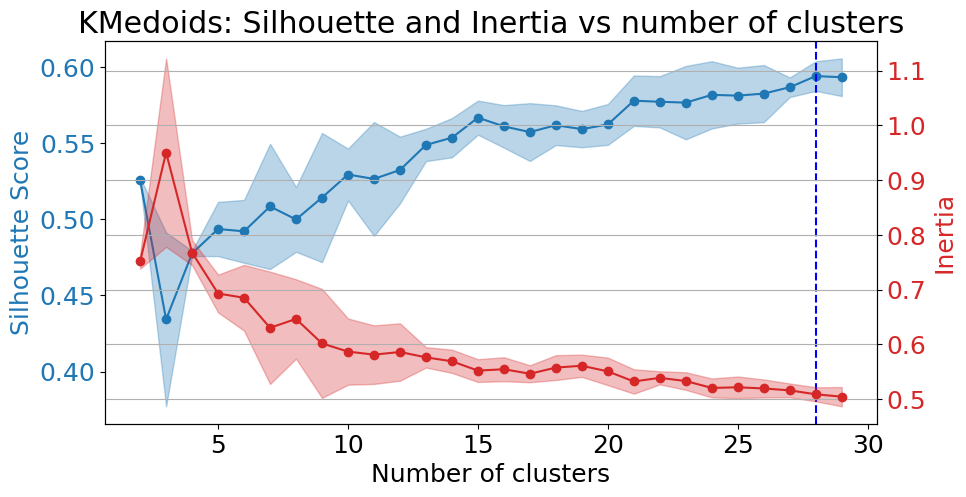

In [197]:
from util.utils import plot_k_medoid_multi_seed
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[2], metrics[3])
plot_k_medoid_multi_seed(2, 30, "euclidean", metrics[0], metrics[1], metrics[4], metrics[5])

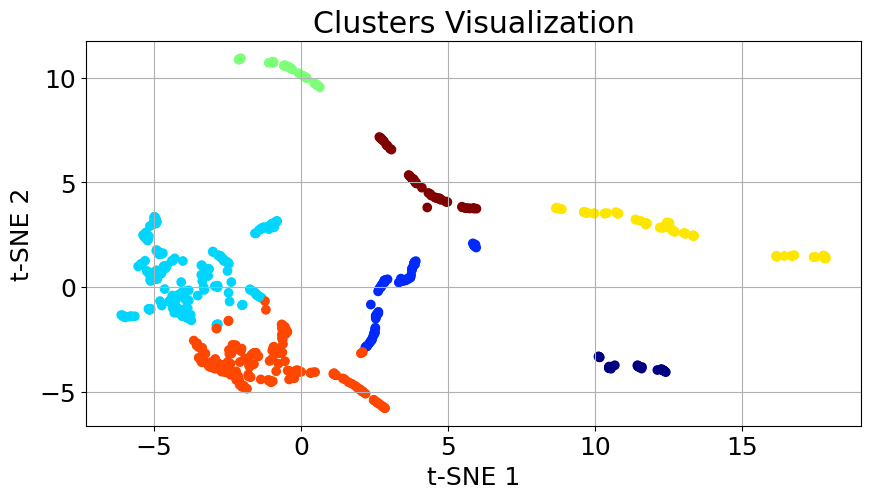

In [201]:
from util.utils import clus_viz
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=7, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')

clus_viz(X_umap, kmedoids, X_umap)


In [199]:
from sklearn.metrics import adjusted_rand_score
kmedoids = KMedoids(n_clusters=7, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')
kmedoids.fit(X_umap)
kmedoids_labels = kmedoids.predict(X_umap)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.03414813805314914


# 4. MLP Classifier

In [202]:
from sklearn.neural_network import MLPClassifier

## 4.1 Find back results from A1

100%|██████████| 50/50 [00:01<00:00, 46.90it/s]


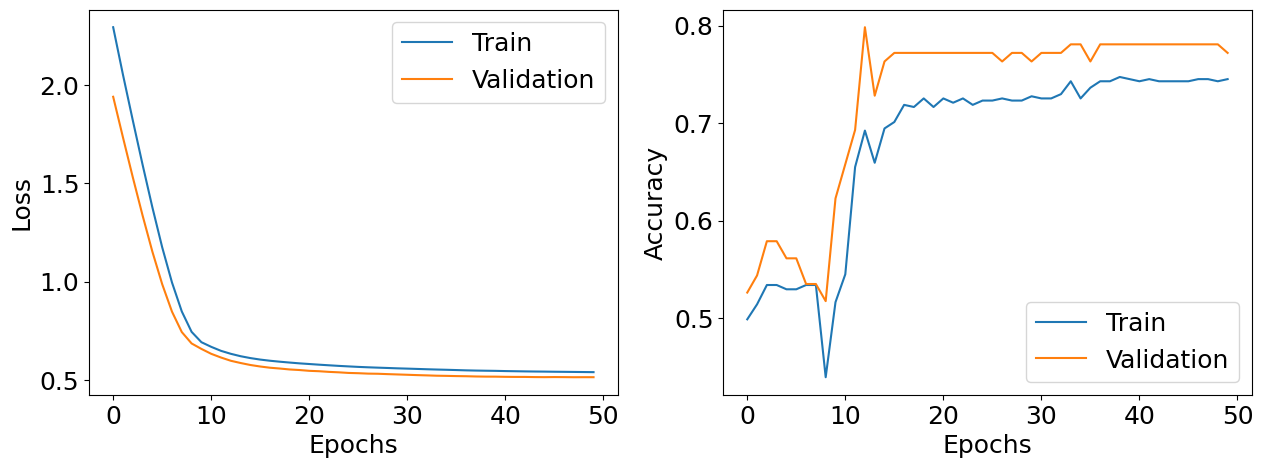

In [277]:
from util.utils import mlp_validation_curve
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(100, 100))
mlp_validation_curve(mlp_model, X_train, y_train)

In [222]:
# test on test set
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=20, hidden_layer_sizes=(100, 100, 100))
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        85
           1       0.74      0.74      0.74        58

    accuracy                           0.79       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143

Accuracy: 0.7902097902097902
F1 Score: 0.7902097902097902


## 4.2 MLP on PCA

In [223]:
# Split X,y into train and test
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

100%|██████████| 50/50 [00:00<00:00, 111.83it/s]


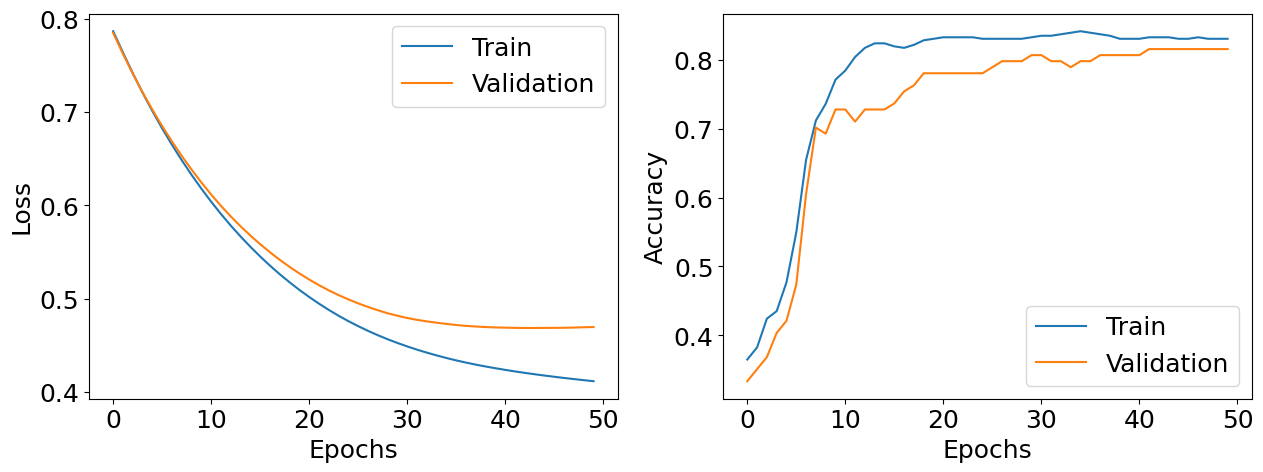

In [278]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(100))
mlp_validation_curve(mlp_model, X_pca_train, y_train)

In [245]:
# test on test set
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=50, warm_start=True, hidden_layer_sizes=(100))
mlp_model.fit(X_pca_train, y_train)
y_pred = mlp_model.predict(X_pca_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        85
           1       0.72      0.76      0.74        58

    accuracy                           0.78       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.78      0.78       143

Accuracy: 0.7832167832167832
F1 Score: 0.7840021901311087


## 4.3 MLP on ICA

In [230]:
# Split X,y into train and test
X_ica_train, X_ica_test, y_train, y_test = train_test_split(X_ica, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

100%|██████████| 50/50 [00:00<00:00, 84.57it/s]


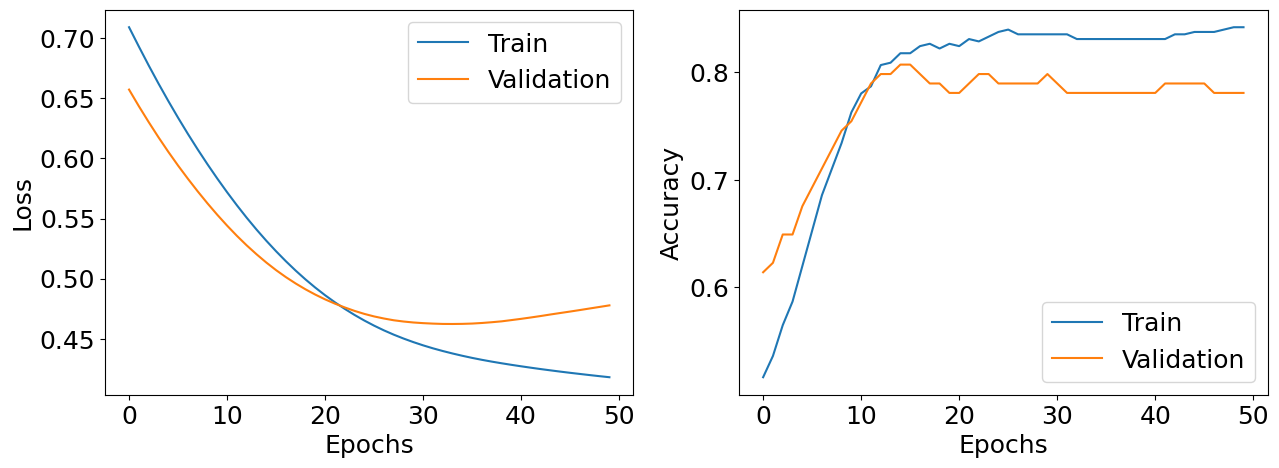

In [279]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(100))
mlp_validation_curve(mlp_model, X_ica_train, y_train)

In [244]:
# test on test set
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=50, warm_start=True)
mlp_model.fit(X_ica_train, y_train)
y_pred = mlp_model.predict(X_ica_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        85
           1       0.75      0.74      0.75        58

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

Accuracy: 0.7972027972027972
F1 Score: 0.7969140445112985


## 4.4 MLP on RP

In [235]:
# Split X,y into train and test
X_grp_train, X_grp_test, y_train, y_test = train_test_split(X_grp, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:02<00:00, 105.50it/s]


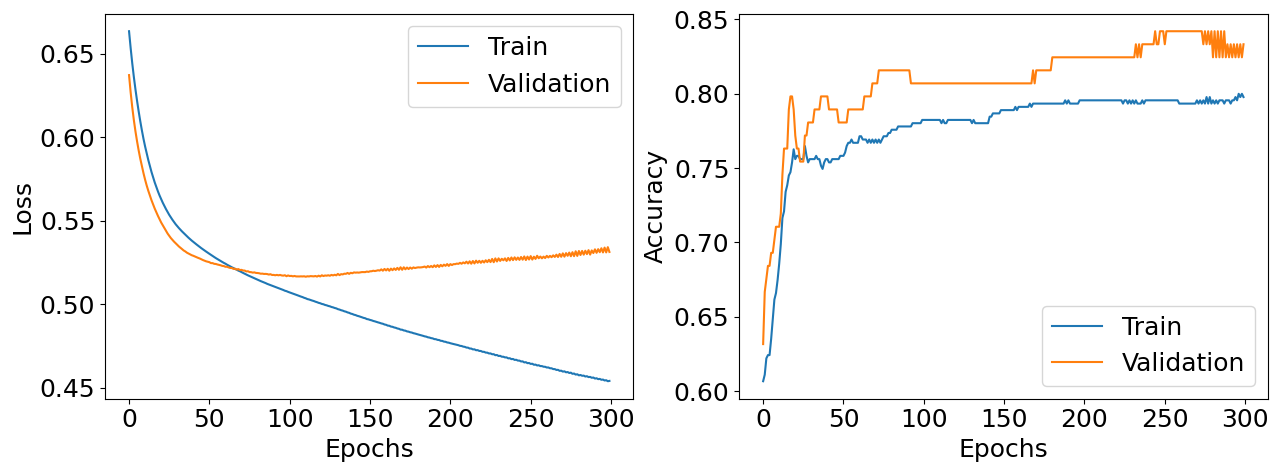

In [282]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(100))
mlp_validation_curve(mlp_model, X_grp_train, y_train, n_epochs=300)

In [283]:
# test on test set
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=300, warm_start=True)
mlp_model.fit(X_grp_train, y_train)
y_pred = mlp_model.predict(X_grp_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        85
           1       0.72      0.74      0.73        58

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143

Accuracy: 0.7762237762237763
F1 Score: 0.7767881835678446


## 4.5 MLP on U-MAP

In [246]:
X_umap_train, X_umap_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:05<00:00, 91.31it/s] 


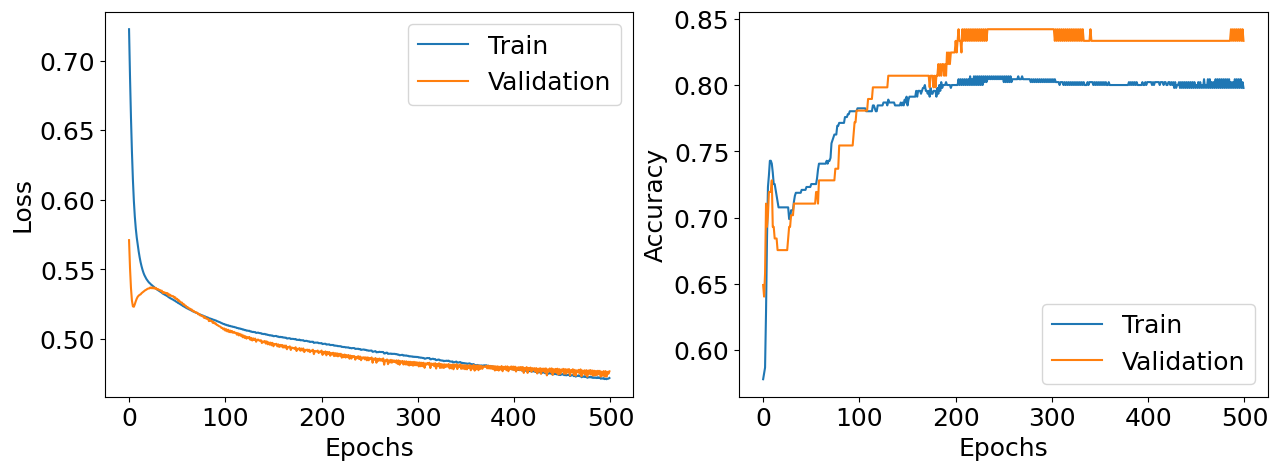

In [287]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(25,25))
mlp_validation_curve(mlp_model, X_umap_train, y_train, n_epochs=500)

In [288]:
# test on test set
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=400, warm_start=False)
mlp_model.fit(X_umap_train, y_train)
y_pred = mlp_model.predict(X_umap_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83        85
           1       0.74      0.78      0.76        58

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

Accuracy: 0.7972027972027972
F1 Score: 0.7979375327032953


# 5: Final Step, MLP with clus labels

In [13]:
# split X,y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 73.92it/s]


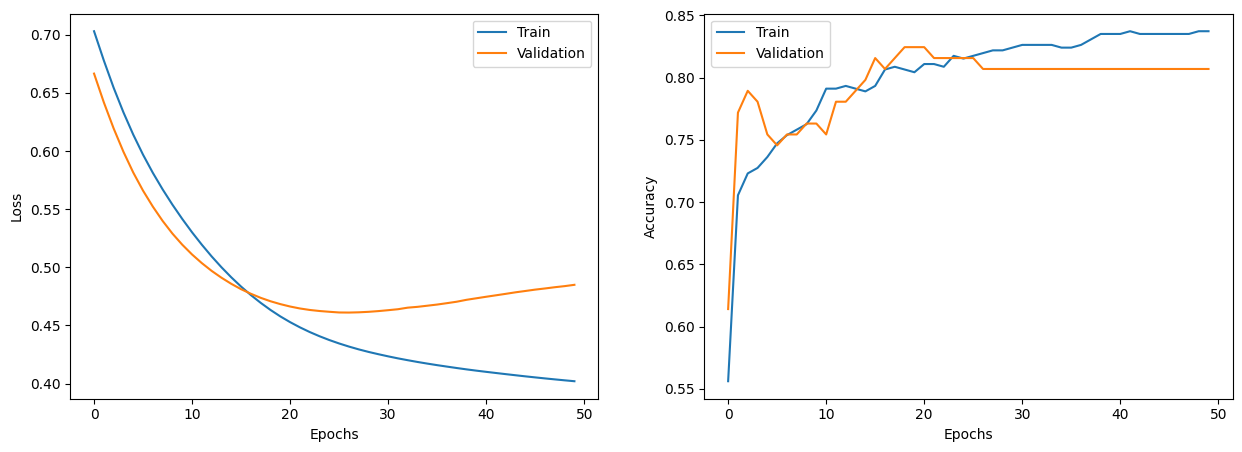

In [24]:
from util.utils import mlp_validation_curve
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(64), learning_rate_init=0.001)

mlp_validation_curve(mlp_model, X_train, y_train, n_epochs=50)


In [35]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=50, hidden_layer_sizes=(100), learning_rate_init=0.001, solver='adam', activation='relu')

mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        85
           1       0.76      0.76      0.76        58

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143

Accuracy: 0.8041958041958042
F1 Score: 0.8041958041958042


In [289]:
from sklearn.metrics import adjusted_rand_score
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=3, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='cosine')
kmedoids.fit(X_scaled)
kmedoids_labels = kmedoids.predict(X_scaled)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.18651092788233603


In [290]:
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7, covariance_type='tied', random_state=RANDOM_SEED)
gmm.fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)
ari = adjusted_rand_score(gmm_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.08474080914288173


In [291]:
X_km = X_scaled
X_gmm = X_scaled

X_km['cluster'] = kmedoids_labels
X_gmm['cluster'] = gmm_labels

from sklearn.model_selection import train_test_split

X_km_train, X_km_test, y_train, y_test = train_test_split(X_km, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
X_gmm_train, X_gmm_test, y_train, y_test = train_test_split(X_gmm, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


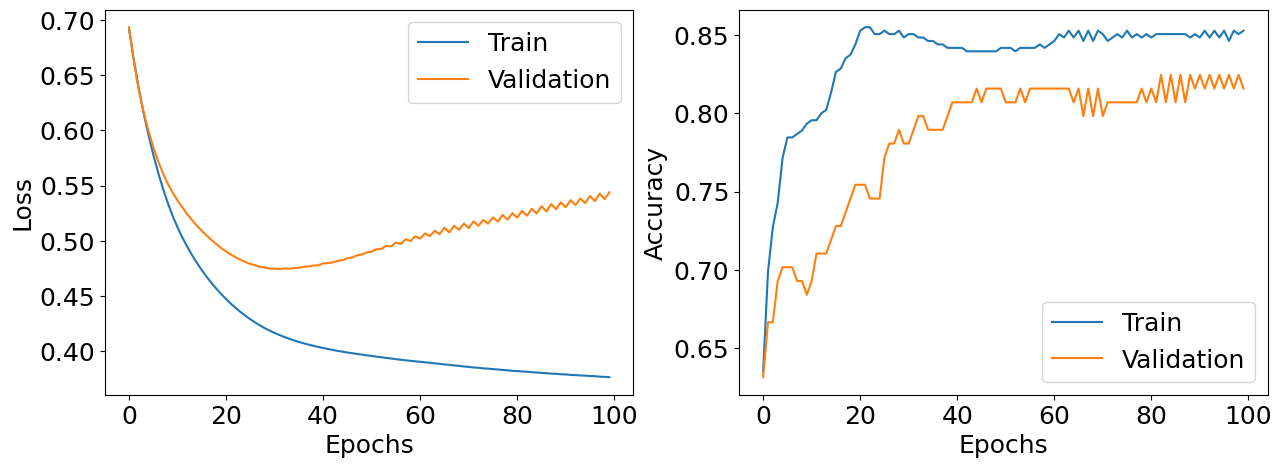

In [295]:
from util.utils import mlp_validation_curve

mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=1, warm_start=True, hidden_layer_sizes=(100,100))

mlp_validation_curve(mlp_model, X_km_train, y_train, n_epochs=100)


In [303]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=20, hidden_layer_sizes=(100,100, 100))

mlp_model.fit(X_km_train, y_train)
y_pred = mlp_model.predict(X_km_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        85
           1       0.78      0.74      0.76        58

    accuracy                           0.81       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

Accuracy: 0.8111888111888111
F1 Score: 0.8103195592069702


In [304]:
mlp_model = MLPClassifier(random_state=RANDOM_SEED, max_iter=20, hidden_layer_sizes=(100,100, 100))

mlp_model.fit(X_gmm_train, y_train)
y_pred = mlp_model.predict(X_gmm_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        85
           1       0.78      0.74      0.76        58

    accuracy                           0.81       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

Accuracy: 0.8111888111888111
F1 Score: 0.8103195592069702
